[View in Colaboratory](https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/MOOC_HPFEM_Fluid.ipynb)

#Welcome to the MOOC-HPFEM fluid simulation module!

Here you will learn how to automatically solve the fundamental balance equations of momentum and mass to compute fluid flow, essential for science and technology in society.



# New Section

<h3 id="direct-fem-simulation-dfs-methodology"><strong>Direct FEM Simulation (DFS) methodology</strong></h3>
<p>Developed over a 20+ year period by Johnson, Hoffman, Jansson, etc.</p>
<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\[\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  p_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
u\cdot n &;=& 0, x \in \Gamma \quad (\text{Slip BC for high Reynolds number})\\
\hat{u} &=& (u, p)
\end{array}\]</span></p>
<p>Weak residual <span class="math inline">$r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v})$</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with Galerkin/least squares stabilization</dt>
<dd><p><span class="math display">\[\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}\]</span></p>
</dd>

The FEniCS formulation of DFS is given below, which you can run and modify yourself.

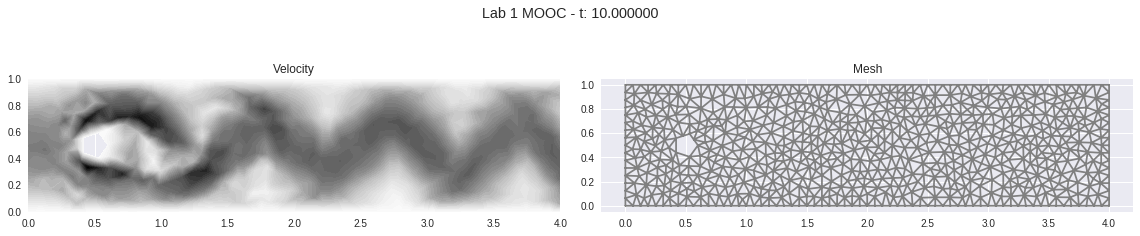

elapsed CPU time:  41.554897


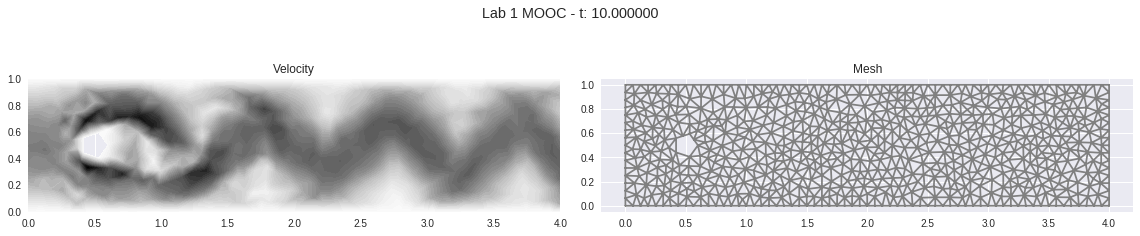

In [1]:
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
import matplotlib.pyplot as plt;
#import plotly.plotly as plt
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5 # Geometry and mesh
mresolution=30
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

# FEM functions
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellSize(mesh);

# Make a mixed space
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE)

(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

def plot_compact(u, t, stepcounter): # Compact plot utility function
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
        plt.subplot(1, 2, 1); plot(uEuclidnorm, scalarbar=True); plt.title("Velocity") # Plot norm of velocity
        if t == 0.: plt.axis(G)
        plt.subplot(1, 2, 2);
        if t == 0.: plot(mesh); plt.title("Mesh") # Plot mesh
        plt.suptitle("Lab 1 MOOC - t: %f" % (t)); plt.tight_layout(); clear_output(wait=True); display(pl);
    
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

k = 0.1; nu = 1e-6; d = .2*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

pl, ax = plt.subplots(); stepcounter = 0; timer0 = time.clock()

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)

    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)

    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep
print "elapsed CPU time: ", (time.clock() - timer0)
